In [43]:
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

In [44]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/cityscapes-image-pairs")

print("Path to dataset files:", path)

"""
Link to original dataset.
https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data

Each image has the original cityscape (left) and the target mask (right) of the image file.
"""

Using Colab cache for faster access to the 'cityscapes-image-pairs' dataset.
Path to dataset files: /kaggle/input/cityscapes-image-pairs


'\nLink to original dataset. \nhttps://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data\n\nEach image has the original cityscape (left) and the target mask (right) of the image file.\n'

In [45]:
# If the downloaded kaggle directory contains an extra nested layer, join from the root
if len(os.listdir(path)) == 1 and os.path.isdir(os.path.join(path, os.listdir(path)[0])):
    path = os.path.join(path, os.listdir(path)[0])

train_pth = os.path.join(path, "train")
val_pth = os.path.join(path, "val")
train_imgs = os.listdir(train_pth)
val_imgs = os.listdir(val_pth)

print(len(train_imgs), len(val_imgs))

2975 500


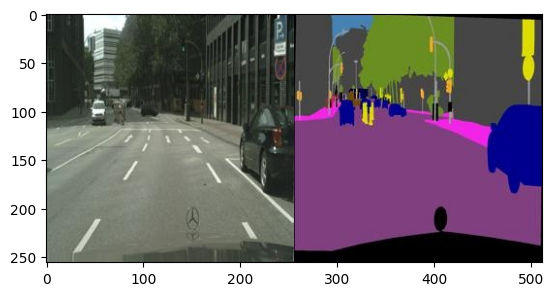

Width: 512, Height: 256


In [46]:
sample = Image.open(os.path.join(train_pth, train_imgs[0]))
plt.imshow(sample)
plt.show()
print(f"Width: {sample.width}, Height: {sample.height}")

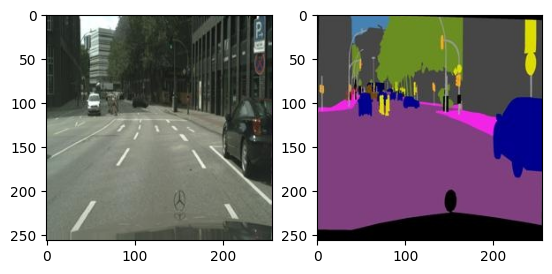

In [47]:
def split_images(img):
  """
  Split the input image into the cityscape and the mask.
  """
  img = np.array(img)
  city, mask = img[:, :256 ,: ], img[:, 256:, :]
  return city, mask

c, m = split_images(sample)
c, m = Image.fromarray(c), Image.fromarray(m)

plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(m)

In [48]:
class SegmentationDataset(Dataset):

  def __init__(self, dir, transforms=None):
    self.dir = dir
    self.images = os.listdir(dir)
    self.transform = transforms

  def __getitem__(self, idx):
    img_pth = os.path.join(self.dir, self.images[idx])
    img = Image.open(img_pth)

    city, mask = self.split_images(img)

    if self.transform:
      city = self.transform(city)
      mask = self.transform(mask)

    return city, mask

  def __len__(self):
    return len(self.images)

  def split_images(self, img):
    """
    Split the input images into city and masks.
    """
    img = np.array(img)
    city, mask = img[:, :256 ,: ], img[:, 256:, :]
    return city, mask



In [112]:
train_data = SegmentationDataset(train_pth)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = SegmentationDataset(val_pth)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [104]:
"""
U-Net model will be used for this semantic segmentation
"""

class DoubleConv(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.dconv_layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        )

  def forward(self, x):
    return self.dconv_layer(x)



class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.block = DoubleConv(in_channels, out_channels)
    self.mp = nn.MaxPool2d(2)


  def forward(self, x):
    x = self.block(x)
    p = self.mp(x)

    return x, p

  def get_skips(self, idx):
    return self.skips[idx]

class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x, skip):
    x = self.up(x)

    if x.shape[2:] != skip.shape[2:]:
      x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
    x = torch.cat([skip, x], axis=1)
    return self.conv(x)


class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.down1 = Down(in_channels, 64)
    self.down2 = Down(64, 128)
    self.down3 = Down(128, 256)
    self.down4 = Down(256, 512)

    self.bottleneck = DoubleConv(512, 1024)

    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)
    self.conv1 = nn.Conv2d(64, self.num_classes, kernel_size=1)

    self.final_act = nn.Softmax(dim=1)

  def forward(self, x):
    s1, d1 = self.down1(x)
    s2, d2 = self.down2(d1)
    s3, d3 = self.down3(d2)
    s4, d4 = self.down4(d3)

    b = self.bottleneck(d4)

    x = self.up1(b, s4)
    x = self.up2(x, s3)
    x = self.up3(x, s2)
    x = self.up4(x, s1)
    x = self.conv1(x)

    return self.final_act(x)


In [106]:
unet = UNet(3, 30)
summary(unet, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
              Down-9  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [ ]:
"""
Believe masks are integer encoded, use categorical cross entropy, adam optims, change LR to 16

remove softmax from network as LFN as it internally.
"""